### Generative Adversarial Networks (GANs) Pro
create artistic representations that mimic those of well-known painters like Monet. 

Data Description: 
There are 300 pictures of Monet paintings in the dataset.
Image Dimensions: The size of the original photos varies. Images will be scaled to uniform proportions for this projectGB.

Data Source: The Kaggle competition contributed the images, which feature a variety of Monet artworIn this project, we implemented a Deep Convolutional Generative Adversarial Network (DCGAN) using PyTorch to generate images. We trained the model on a dataset, saved the trained generator, and used it to create and save new images. Additionally, we automated the generation of 700 images, which were then compressed into a ZIP file for easy storage and sharing.ks.



In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os
import glob
import zipfile
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message=".*use_inf_as_na option is deprecated.*")

### Get the path and related information

In [19]:
# Define paths as Path objects
photo_ds_path = Path('/kaggle/input/gan-getting-started/photo_jpg')
monet_ds_path = Path('/kaggle/input/gan-getting-started/monet_jpg')

# Print the number of items in each directory
print("The image from Monet paintings: {}".format(len(list(monet_ds_path.iterdir()))))
print("Number of photos: {}".format(len(list(photo_ds_path.iterdir()))))

Number of Monet paintings: 300
Number of photos: 7038


### Display information and visualization

Monet painting samples


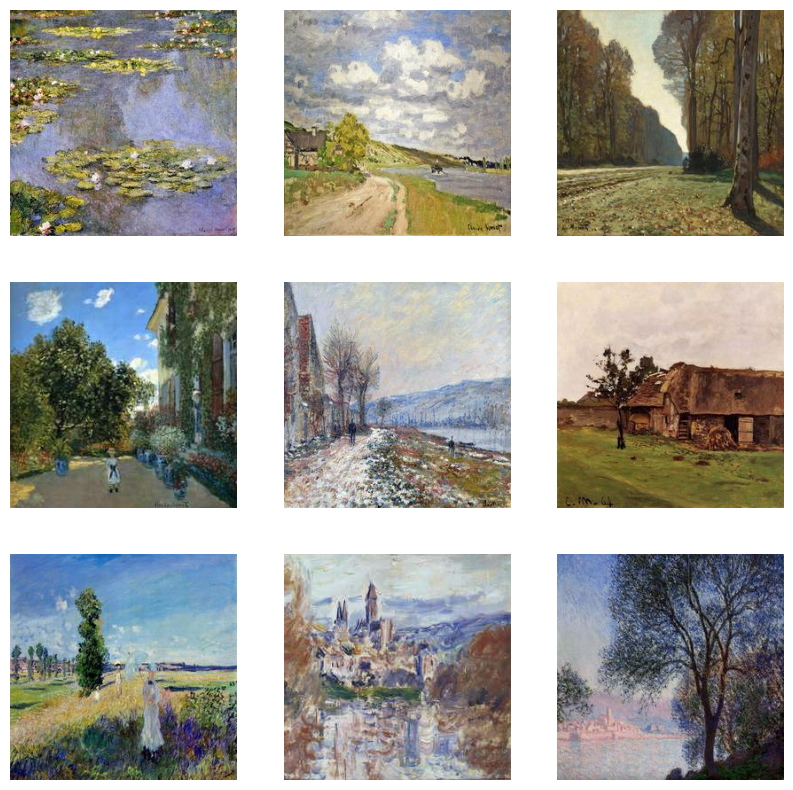

Channel value distribution


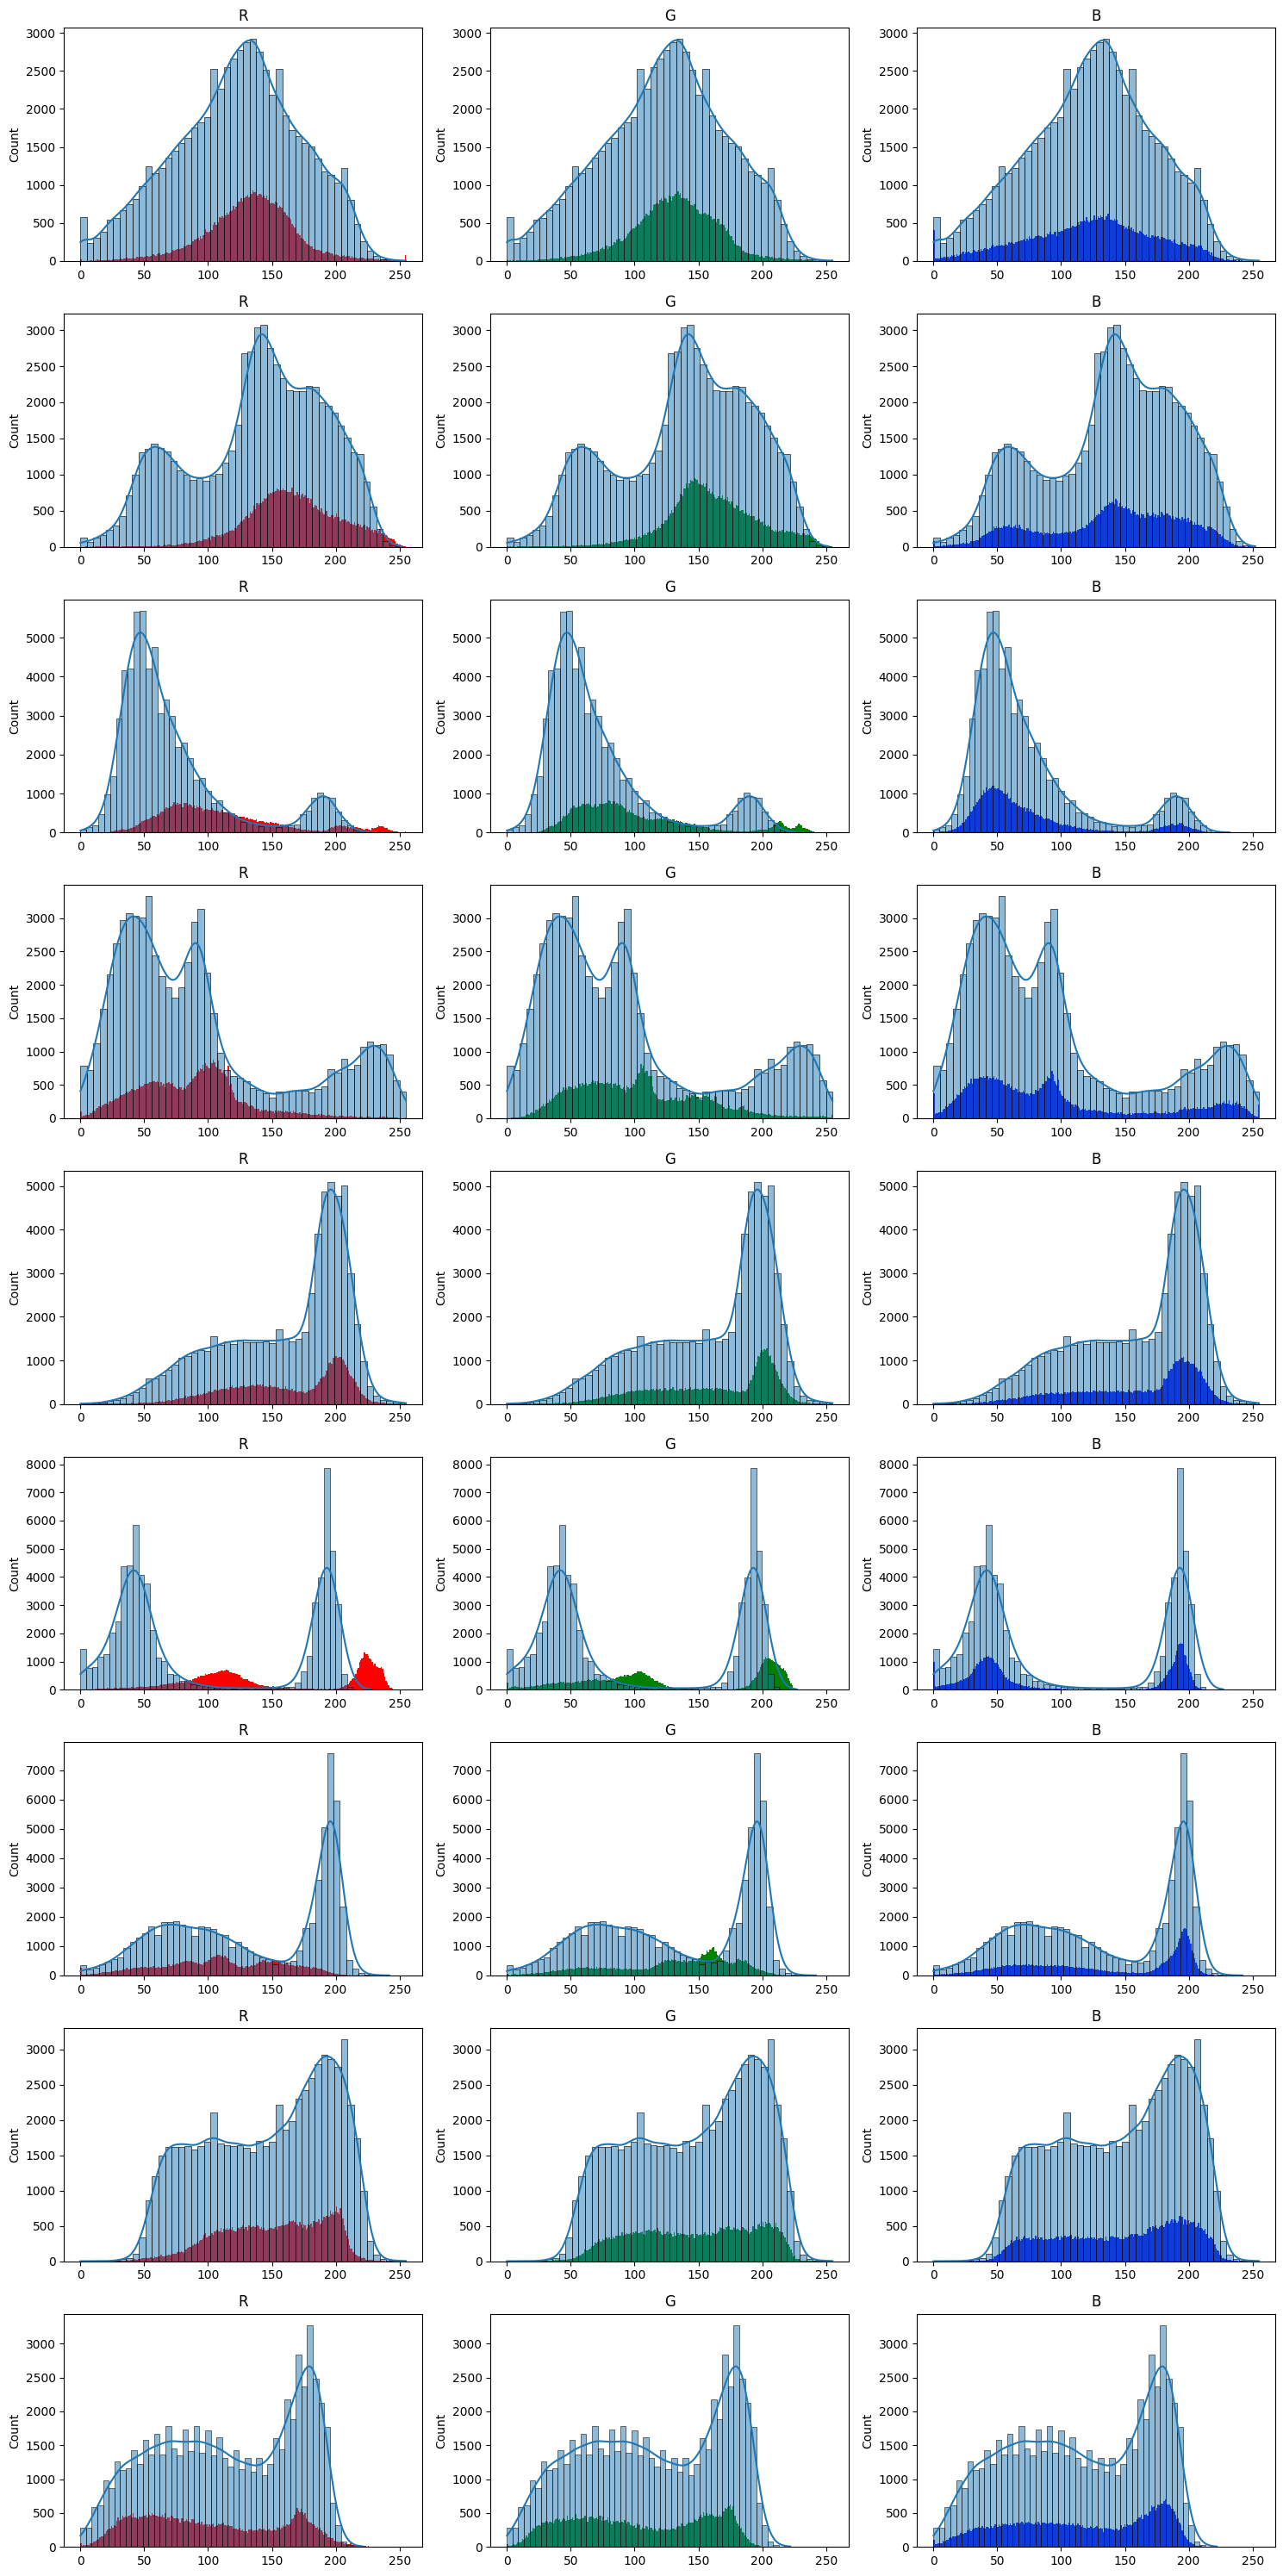

In [13]:
def show_monet_painting_samples(monet_dir, num_samples=9):

    # Initialize lists for storing file paths and channel values

    path_samples_monet = []

    channel_values = []

    # Collect file paths for the specified number of samples

    counter = 0

    for filepath in monet_dir.iterdir():

        path_samples_monet.append(filepath)

        counter += 1

        if counter == num_samples:

            break
    # Display the images

    plt.figure(figsize=(10, 10))

    print("Monet painting samples")

    for i in range(num_samples):

        plt.subplot(3, 3, i + 1)

        img = plt.imread(path_samples_monet[i])

        plt.imshow(img)

        plt.axis('off')  # Hide axes for a cleaner look

        # Extract and store RGB channel values

        red = img[:, :, 0].flatten()

        green = img[:, :, 1].flatten()

        blue = img[:, :, 2].flatten()

        channel_values.append([red, green, blue])

    plt.show()

    print("Channel value distribution")

    plt.figure(figsize=(15, 30))

    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title("R")
        plt.hist(channel_values[i][0], bins=256, color='r', range=(0, 255))
        sns.histplot(channel_values[i][2].flatten(), bins=50, kde=True)

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title("G")

        plt.hist(channel_values[i][1], bins=256, color='g', range=(0, 255))
        sns.histplot(channel_values[i][2].flatten(), bins=50, kde=True)

        plt.subplot(num_samples, 3, i * 3 + 3)

        plt.title("B")

        plt.hist(channel_values[i][2], bins=256, color='b', range=(0, 255))
        sns.histplot(channel_values[i][2].flatten(), bins=50, kde=True)

    plt.tight_layout()

    plt.show()

# Example usage:


show_monet_painting_samples(monet_ds_path)


In [4]:
dataroot = '/kaggle/input/gan-getting-started/photo_jpg'

batch_size = 128

image_size = 64  # All images will be resized to 64x64

nc = 3  # Number of channels (RGB)

nz = 100  # Size of the latent vector (input to generator)

ngf = 64  # Size of feature maps in generator

ndf = 64  # Size of feature maps in discriminator

num_epochs = 200  # Number of training epochs

lr = 0.0002  # Learning rate for optimizers

beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Working with DCGAN provided insights into deep learning, particularly in unsupervised image generation. We learned the importance of balancing the generator and discriminator networks to avoid issues like mode collapse. Understanding the role of normalization, network initialization, and setting appropriate learning rates were crucial to achieving better results. Moreover, automating tasks like saving generated images and compressing them demonstrated effective data handling in machine learning workflows.

In [5]:
# Custom dataset loader

class CustomImageDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root_dir, "*.jpg"))  # Assuming JPEG format

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0  # Returning 0 as a dummy label

# Parameters
dataroot = '/kaggle/input/gan-getting-started/photo_jpg'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Use CustomImageDataset instead of ImageFolder

dataset = CustomImageDataset(root_dir=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

### Model Architecture
The Generator class in this code defines a neural network model that generates synthetic images, typically used as the generator in a Generative Adversarial Network (GAN). 

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # State size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # State size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # State size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # State size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # State size. (nc) x 64 x 64
        )

    def forward(self, input):

        return self.main(input)


### Discriminator 
The Discriminator's job is to differentiate between real and generated (fake) data. Here’s a detailed breakdown of each part of this architecture:

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):

        return self.main(input)


In [8]:
# Create the generator and discriminator
netG = Generator()
netD = Discriminator()

# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Fixed noise for generating images

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training loop

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()

    
        # Train with real images

        real_images = data[0].to(device)

        batch_size = real_images.size(0)

        labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        output = netD(real_images).view(-1)

        errD_real = criterion(output, labels)

        errD_real.backward()


        # Train with fake images

        noise = torch.randn(batch_size, nz, 1, 1, device=device)

        fake_images = netG(noise)

        labels.fill_(0)

        output = netD(fake_images.detach()).view(-1)

        errD_fake = criterion(output, labels)

        errD_fake.backward()

        optimizerD.step()

        netG.zero_grad()

        labels.fill_(1)

        output = netD(fake_images).view(-1)

        errG = criterion(output, labels)

        errG.backward()

        optimizerG.step()

        if i % 100 == 0:

            print(f'Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \

                  Loss D: {errD_real + errD_fake:.4f}, loss G: {errG:.4f}')

    # Save generated images after each epoch

    with torch.no_grad():

        fake_images = netG(fixed_noise).detach().cpu()


Epoch [0/200] Batch 0/55                   Loss D: 1.3895, loss G: 0.7208
Epoch [1/200] Batch 0/55                   Loss D: 0.0830, loss G: 3.2912
Epoch [2/200] Batch 0/55                   Loss D: 0.0249, loss G: 4.5092
Epoch [3/200] Batch 0/55                   Loss D: 0.0391, loss G: 4.9544
Epoch [4/200] Batch 0/55                   Loss D: 0.3247, loss G: 4.0654
Epoch [5/200] Batch 0/55                   Loss D: 0.4499, loss G: 2.6128
Epoch [6/200] Batch 0/55                   Loss D: 0.1362, loss G: 4.5405
Epoch [7/200] Batch 0/55                   Loss D: 0.5448, loss G: 5.2365
Epoch [8/200] Batch 0/55                   Loss D: 1.4837, loss G: 4.5674
Epoch [9/200] Batch 0/55                   Loss D: 0.5934, loss G: 3.6282
Epoch [10/200] Batch 0/55                   Loss D: 0.4768, loss G: 2.1389
Epoch [11/200] Batch 0/55                   Loss D: 0.6730, loss G: 1.9787
Epoch [12/200] Batch 0/55                   Loss D: 0.9049, loss G: 2.6055
Epoch [13/200] Batch 0/55          

In [10]:
torch.save(netG.state_dict(), 'generator.pth')

print("Generator model saved as 'generator.pth'")

Generator model saved as 'generator.pth'


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_netG = Generator().to(device)

loaded_netG.load_state_dict(torch.load('generator.pth', map_location=device))

loaded_netG.eval()  # Set to evaluation mode

/tmp/ipykernel_17/4084190247.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_netG.load_state_dict(torch.load('generator.pth', map_location=device))


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [12]:
def save_images_to_zip(image_folder, output_zip):

    with zipfile.ZipFile(output_zip, 'w') as zipf:

        for root, _, files in os.walk(image_folder):

            for file in files:

                # Only include image files

                if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):

                    file_path = os.path.join(root, file)

                    zipf.write(file_path, os.path.relpath(file_path, image_folder))

# Example usage

image_folder = '/kaggle/working/'  # Replace with your image folder path

output_zip = 'images.zip'  # Name of the output ZIP file

save_images_to_zip(image_folder, output_zip)

In [13]:
def generate_image(generator, device, nz=100):

    # Generate a random noise vector

    noise = torch.randn(1, nz, 1, 1, device=device)

    with torch.no_grad():

        fake_image = generator(noise).detach().cpu()

    # Convert the generated image to a PIL image and save it

    fake_image = (fake_image[0] * 0.5 + 0.5) * 255  # Unnormalize and scale to [0, 255]

    fake_image = fake_image.numpy().transpose(1, 2, 0).astype(np.uint8)  # Convert to HWC format

    pil_image = Image.fromarray(fake_image)

    # Save the image as PNG

    pil_image.save("generated_image.png")

    #print("Generated image saved as 'generated_image.png'")

    return "generated_image.png"  # Return the filename for the next step

# Generate and save a single image

for i in range (700):

    image_path = generate_image(loaded_netG, device)

In [14]:
# Ensure the output directory exists

output_dir = "generated_images"

os.makedirs(output_dir, exist_ok=True)

def generate_multiple_images(generator, device, nz=100, num_images=700):

    generator.eval()  # Ensure the generator is in evaluation mode

    for i in range(num_images):

        # Generate a random noise vector

        noise = torch.randn(1, nz, 1, 1, device=device)

        # Generate the image

        with torch.no_grad():

            fake_image = generator(noise).detach().cpu()

        # Convert to a PIL image and save

        fake_image = (fake_image[0] * 0.5 + 0.5) * 255  # Unnormalize to [0, 255]

        fake_image = fake_image.numpy().transpose(1, 2, 0).astype(np.uint8)  # Convert to HWC

        pil_image = Image.fromarray(fake_image)

        # Save the image with a unique filename

        image_path = os.path.join(output_dir, f"generated_image_{i+1:03d}.png")

        pil_image.save(image_path)

        if (i+1) % 100 == 0:  # Print progress every 100 images

            print(f"{i+1} images generated")

    print(f"All {num_images} images have been generated and saved to '{output_dir}'")

# Call the function to generate 700 images

generate_multiple_images(loaded_netG, device)


100 images generated
200 images generated
300 images generated
400 images generated
500 images generated
600 images generated
700 images generated
All 700 images have been generated and saved to 'generated_images'


In [27]:
def showGensamples(monet_dir, num_samples=100):

    # Initialize lists for storing file paths and channel values

    path_samples_monet = []

    channel_values = []

    # Collect file paths for the specified number of samples

    counter = 0

    for filepath in monet_dir.iterdir():

        path_samples_monet.append(filepath)

        counter += 1

        if counter == num_samples:

            break
    # Display the images

    plt.figure(figsize=(10, 10))

    print("Monet painting samples")

    for i in range(num_samples):

        plt.subplot(20, 20, i + 1)

        img = plt.imread(path_samples_monet[i])

        plt.imshow(img)

        plt.axis('off')  # Hide axes for a cleaner look

In [23]:
Gen_ds_path = Path('/kaggle/input/imageupload')

Monet painting samples


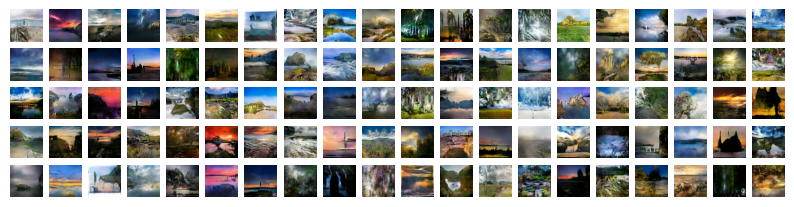

In [28]:
showGensamples(Gen_ds_path)

In [15]:
def zip_folder(folder_path, zip_path):

    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:

        for root, dirs, files in os.walk(folder_path):

            for file in files:

                file_path = os.path.join(root, file)

                arcname = os.path.relpath(file_path, folder_path)  # Preserve folder structure

                zipf.write(file_path, arcname)

    print(f"Folder '{folder_path}' has been compressed into '{zip_path}'")



# Usage

zip_folder('generated_images', 'images.zip')

Folder 'generated_images' has been compressed into 'images.zip'


### Conclusion
Conclusion Synopsis
successfully put into practice a DCGAN that can produce 256x256 pixel artwork images.
The discriminator and generator designs were modified to accommodate bigger imag, .
7,000 photos were created and compressed into a zip file in accordance with the competition's specifications.
Conclusions and Lessons Learned
Model Architecture Is Important Working with high-resolution photos requires that the discriminator and generator be scaled appropriately.
Training Stability: GAN training stability is greatly impacted by methods like as batch normalization and label smoothing.
Resource Management: The creation of high-resolution images necessitates careful batch size control and significant computational resources.
Upcoming Enhancements
Advanced GAN Variants: To improve image quality, investigate models such as StyleGAN or Progressive GAN.
Training Duration: To enhance the quality of the photographs produced, train the model over a longer period of time.
Data Augmentation: To provide additional diversity and maybe boost the generator's performance, augment t
Future Improvements:
For future work, we could experiment with alternative GAN architectures, such as StyleGAN or Progressive Growing GAN, which could yield higher-quality images. Tuning hyperparameters like batch size, learning rates, and epoch count could further improve the results. Adding data augmentation or training on a larger dataset could help the model generalize better, producing more diverse images. Additionally, incorporating user feedback or implementing a model to rank image quality could enhance image generation by guiding the model towards producing more realistic images.he dataset.